# Import necessary libraries

### Data visualization

### No Contrails in this image

## Data visualization with Contrails

### In this image we can see contrails appear

## Load & Preprocess Dataset

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Enable mixed precision for 2-3x speedup
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Load patch IDs
patch_ids = os.listdir(train_path)
print(f"Found {len(patch_ids)} patches")

# SPEED OPTIMIZATION: Use only 25% of data for fast training
patch_ids = patch_ids[:len(patch_ids)//4]  # Use 5000 patches instead of 20000
print(f"Using {len(patch_ids)} patches for fast training")

2025-10-18 09:31:53.594790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760779913.811662      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760779913.876305      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20529 patches
Using 5132 patches for fast training


In [2]:
def compute_band_stats(patch_ids, train_path, sample_size=50):
    """Compute global band statistics from a small sample"""
    band_mins = [np.inf] * 16
    band_maxs = [-np.inf] * 16
    
    sample_ids = np.random.choice(patch_ids, min(sample_size, len(patch_ids)), replace=False)
    
    for pid in tqdm(sample_ids, desc="Computing band stats"):
        patch_folder = os.path.join(train_path, pid)
        
        for b in range(16):
            band_path = os.path.join(patch_folder, f"band_{b+1:02d}.npy")
            if os.path.exists(band_path):
                band_data = np.load(band_path)
                band_mins[b] = min(band_mins[b], band_data.min())
                band_maxs[b] = max(band_maxs[b], band_data.max())
    
    return band_mins, band_maxs

# Compute statistics quickly
band_mins, band_maxs = compute_band_stats(patch_ids, train_path, sample_size=50)
print("Band statistics computed!")

Computing band stats: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

Band statistics computed!


In [3]:
import random
import tensorflow as tf

def fast_generator(patch_ids, train_path, band_mins, band_maxs, batch_size=16, include_negatives=True):
    """Optimized generator with negative samples"""
    while True:
        shuffled_ids = patch_ids.copy()
        np.random.shuffle(shuffled_ids)
        
        for i in range(0, len(shuffled_ids), batch_size):
            batch_ids = shuffled_ids[i:i + batch_size]
            X_batch, y_batch = [], []
            
            for pid in batch_ids:
                patch_folder = os.path.join(train_path, pid)
                
                # Load bands
                bands = []
                for b in range(1, 17):
                    band_path = os.path.join(patch_folder, f"band_{b:02d}.npy")
                    if os.path.exists(band_path):
                        band_data = np.load(band_path)
                        # Normalize
                        band_norm = (band_data - band_mins[b-1]) / (band_maxs[b-1] - band_mins[b-1] + 1e-6)
                        bands.append(band_norm)
                
                if len(bands) != 16:
                    continue
                
                image = np.stack(bands, axis=-1)
                
                # Load mask
                mask_file = os.path.join(patch_folder, "human_pixel_masks.npy")
                if os.path.exists(mask_file):
                    mask = np.load(mask_file)
                    mask = np.expand_dims(mask, axis=-1)
                    
                    # Include positives and some negatives
                    if mask.sum() > 0 or (include_negatives and random.random() < 0.25):
                        # Apply augmentation
                        if random.random() > 0.5:
                            image = np.fliplr(image)
                            mask = np.fliplr(mask)
                        if random.random() > 0.5:
                            image = np.flipud(image)
                            mask = np.flipud(mask)
                        
                        X_batch.append(image)
                        y_batch.append(mask)
                
                if len(X_batch) >= batch_size:
                    break
            
            if len(X_batch) > 0:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

# Split data
train_ids, val_ids = train_test_split(patch_ids, test_size=0.2, random_state=42)

print(f"Train patches: {len(train_ids)}")
print(f"Validation patches: {len(val_ids)}")

# Calculate steps (reduced for speed)
train_steps = len(train_ids) // 16  # Batch size 16
val_steps = len(val_ids) // 16

# Cap steps for faster epochs
train_steps = min(train_steps, 300)  # Max 300 steps per epoch
val_steps = min(val_steps, 50)       # Max 50 validation steps

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

Train patches: 4105
Validation patches: 1027
Train steps per epoch: 256
Validation steps per epoch: 50


## Split into train & test

## Build U-Net Model

In [16]:
!ls -la /kaggle/input/google-research-identify-contrails-reduce-global-warming

total 17068
drwxr-xr-x     5 nobody nogroup        0 Oct 17 12:12 .
drwxr-xr-x     3 root   root        4096 Oct 18 09:31 ..
-rw-r--r--     1 nobody nogroup       76 Oct 17 11:43 sample_submission.csv
drwxr-xr-x     4 nobody nogroup        0 Oct 17 11:43 test
drwxr-xr-x 20531 nobody nogroup        0 Oct 17 12:10 train
-rw-r--r--     1 nobody nogroup 16018622 Oct 17 12:10 train_metadata.json
drwxr-xr-x  1858 nobody nogroup        0 Oct 17 12:12 validation
-rw-r--r--     1 nobody nogroup  1448528 Oct 17 12:12 validation_metadata.json


In [19]:
import json

with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    meta = json.load(f)

print(type(meta))
print(len(meta))
print(meta[0])  # show one entry


<class 'list'>
20529
{'record_id': '3283699311323360356', 'projection_wkt': 'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]', 'row_min': 1686563.5, 'row_size': -1960.975830078125, 'col_min': 371650.9375, 'col_size': 1947.1307373046875, 'timestamp': 1571008800.0}


2025-10-18 10:38:33.252222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760783913.561025      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760783913.654717      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Loading metadata...
Training samples: 20529
Validation samples: 1856
Creating U-Net model...


2025-10-18 10:38:50.864534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

Loading training data...
Creating train dataset with 1000 samples...


100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


Successfully loaded 1000/1000 samples for train
Loading validation data...
Creating validation dataset with 200 samples...


100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


Successfully loaded 200/200 samples for validation
Training data shape: (1000, 256, 256, 3)
Training masks shape: (1000, 256, 256)
Validation data shape: (200, 256, 256, 3)
Validation masks shape: (200, 256, 256)
Training masks shape after expansion: (1000, 256, 256, 1)
Validation masks shape after expansion: (200, 256, 256, 1)
Starting training...
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 4714s 147s/step - accuracy: 0.9414 - io_u: 0.0000e+00 - loss: 0.3437 - val_accuracy: 0.9982 - val_io_u: 0.0000e+00 - val_loss: 0.5076 - learning_rate: 1.0000e-04
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 4632s 144s/step - accuracy: 0.9950 - io_u: 0.0000e+00 - loss: 0.1469 - val_accuracy: 0.9982 - val_io_u: 0.0000e+00 - val_loss: 0.3594 - learning_rate: 1.0000e-04


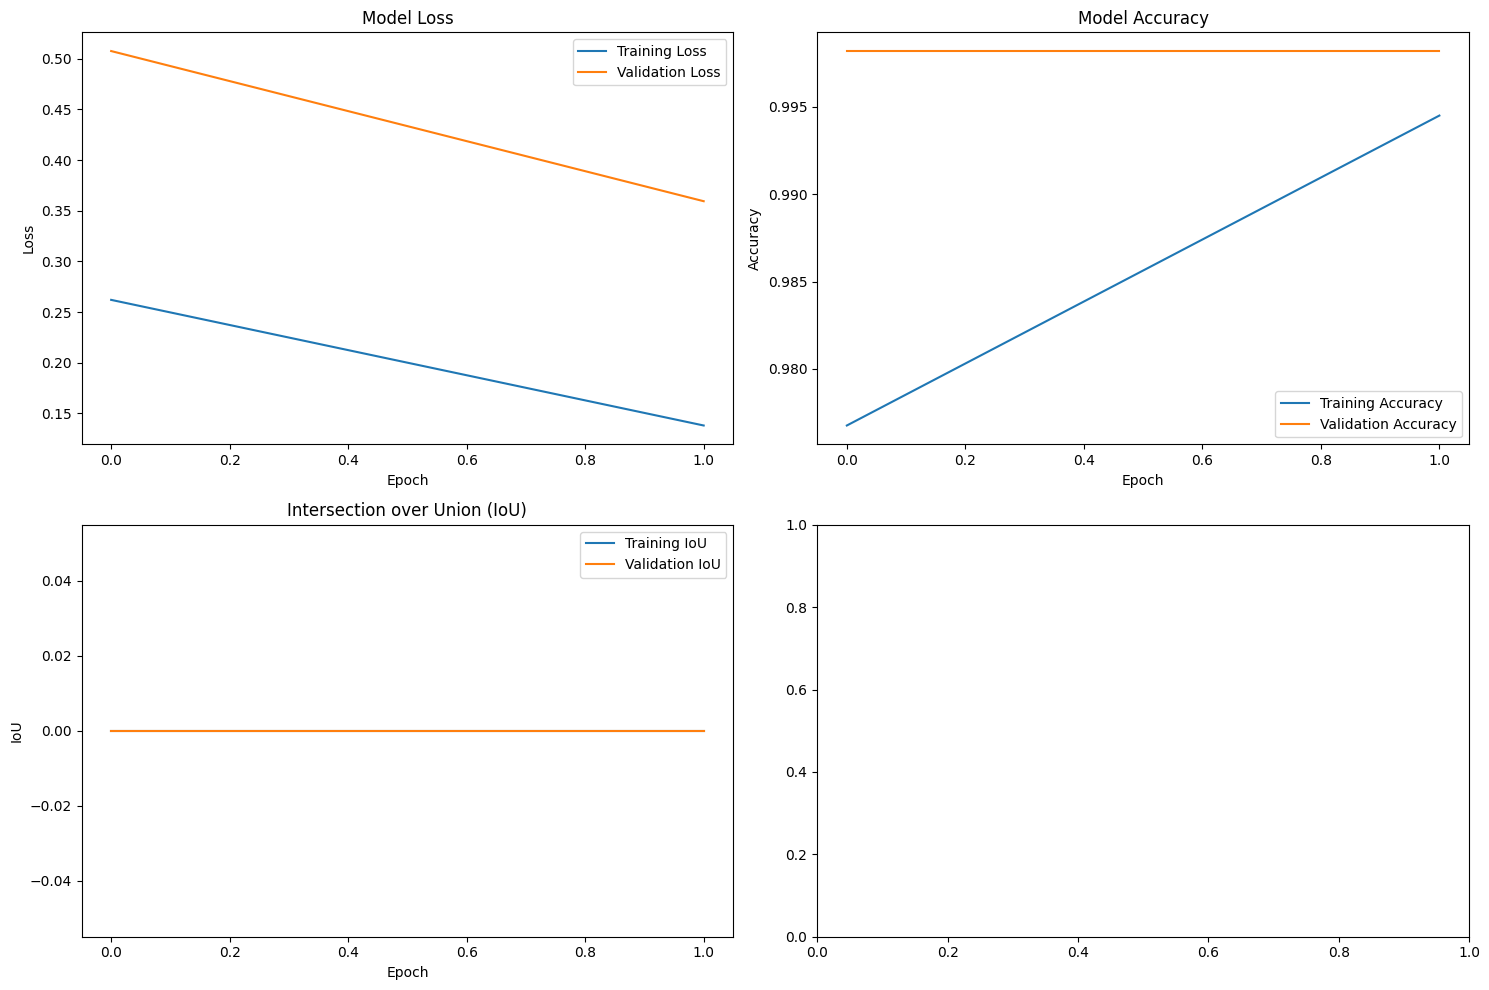

Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


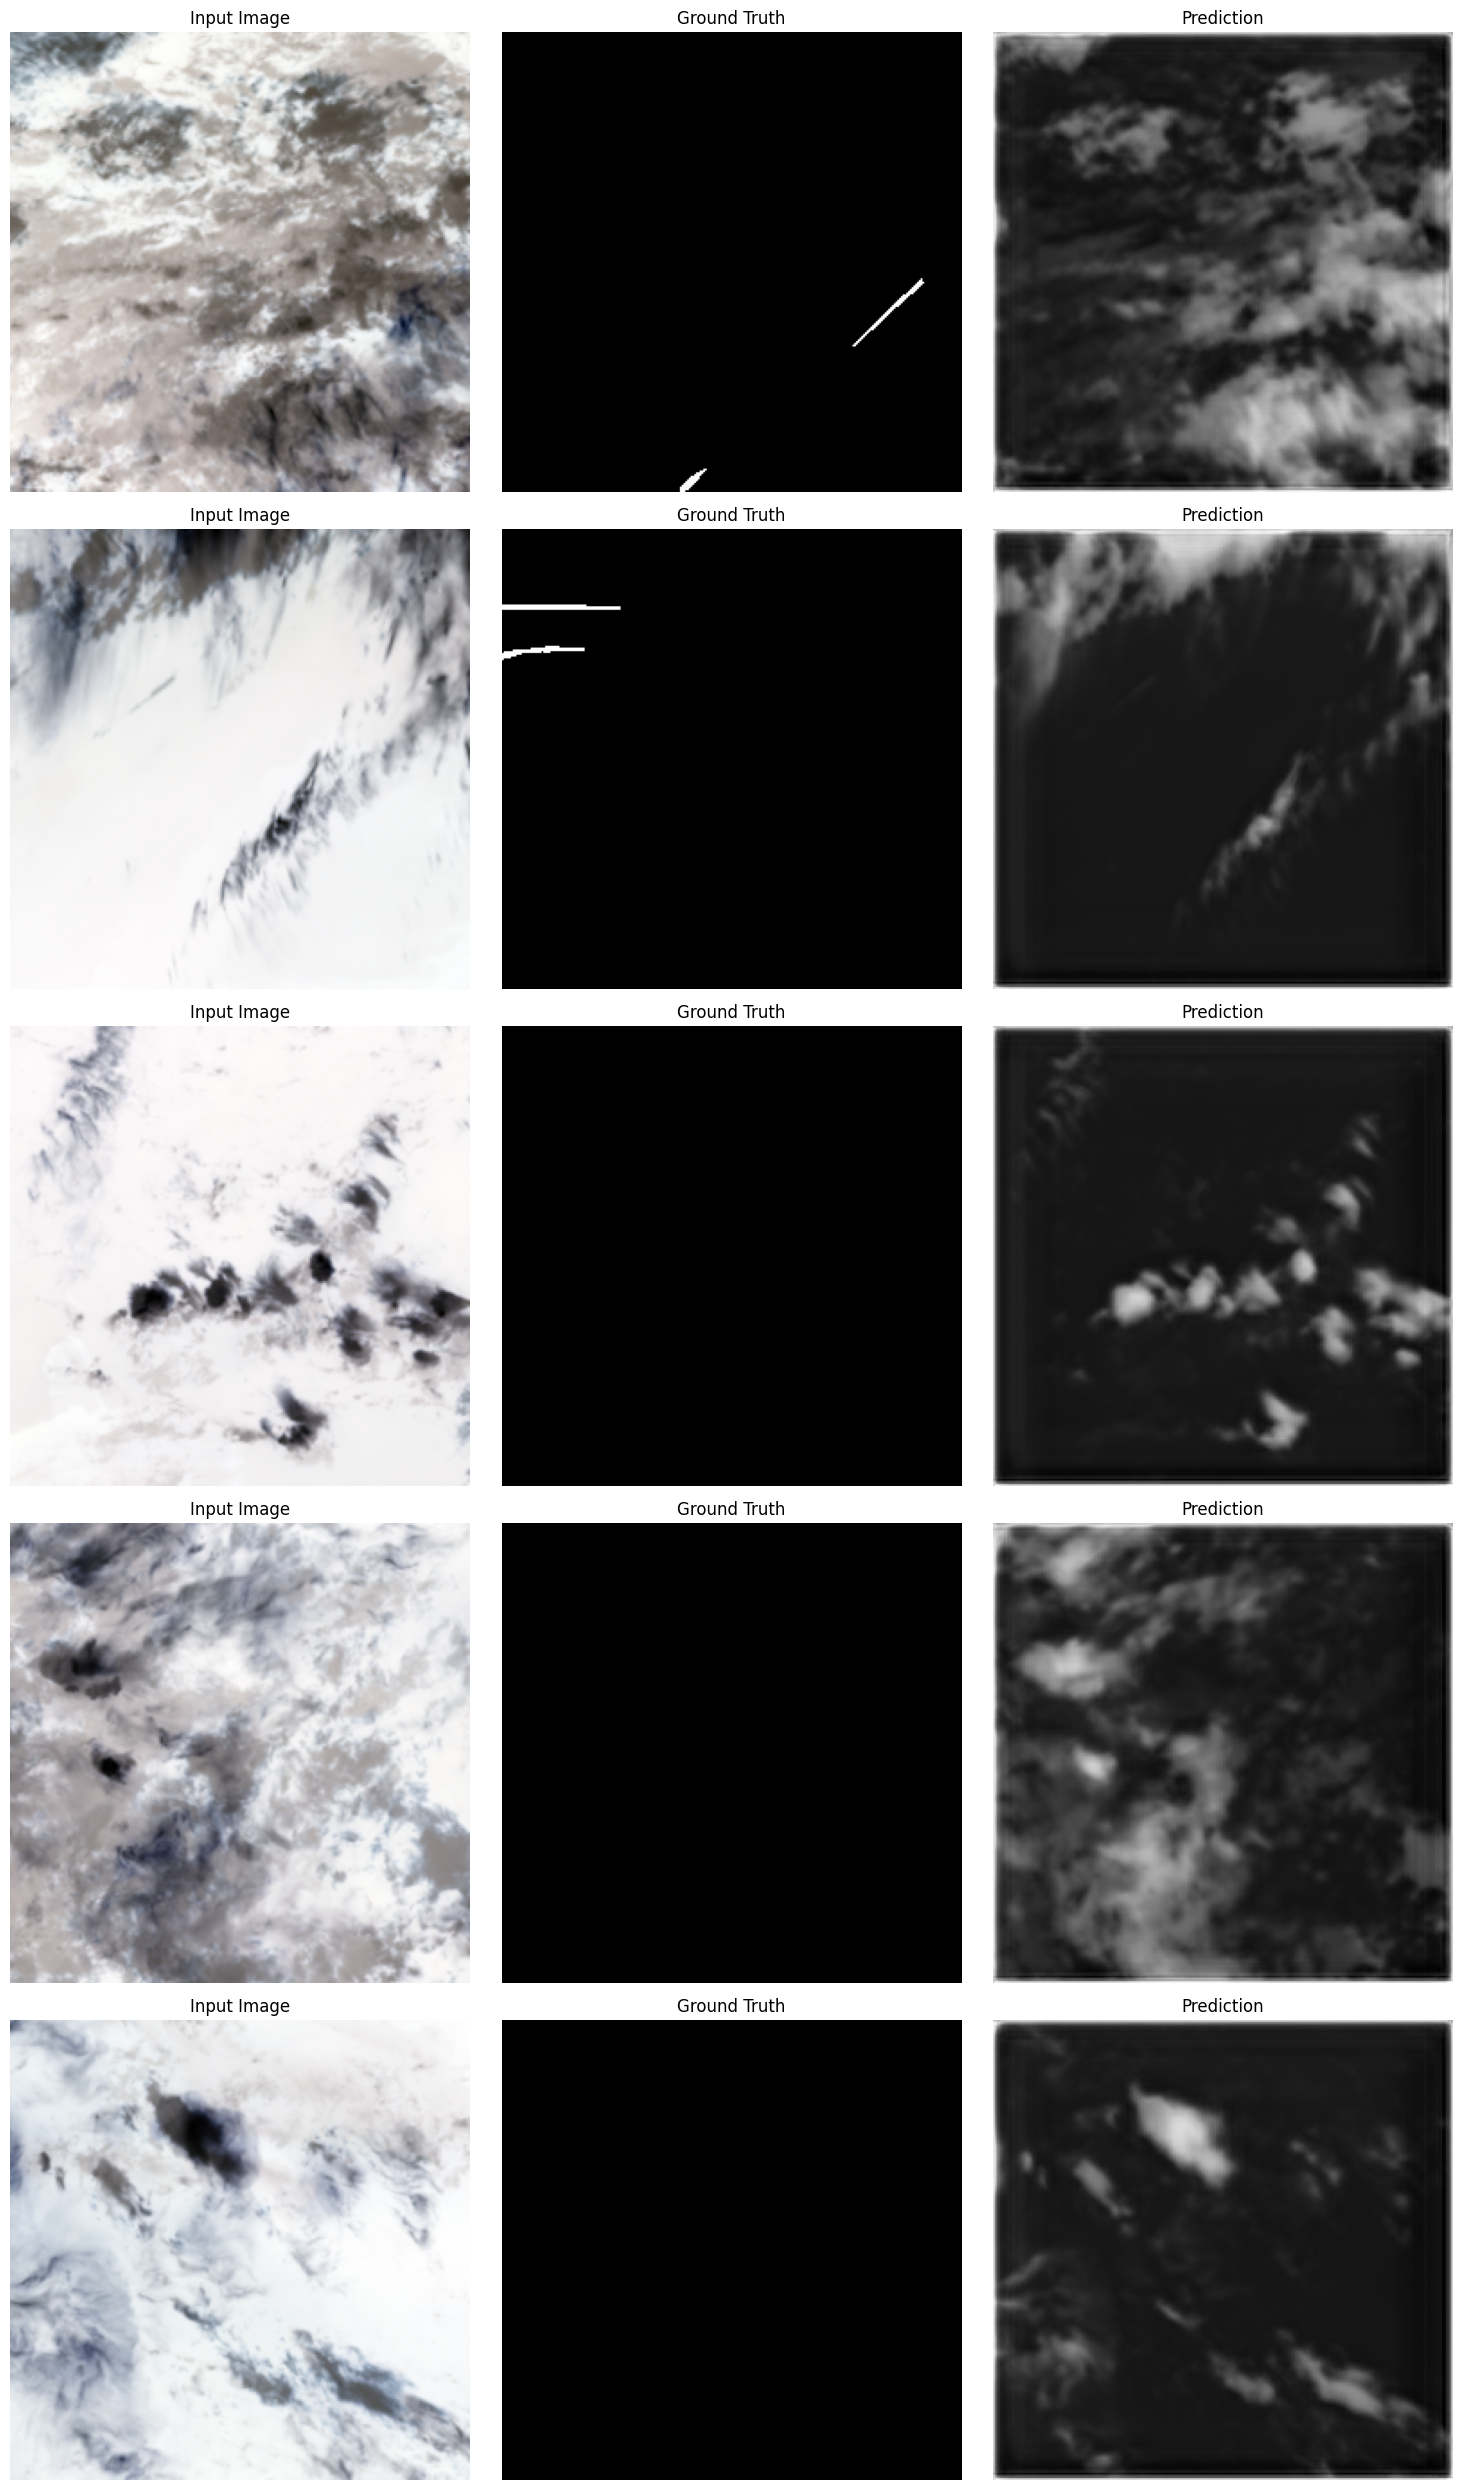

Model saved as 'contrail_detection_model.h5'
Evaluating model...
Test Loss: 0.3594
Test Accuracy: 0.9982
Test IoU: 0.0000
Creating submission file...
Creating submission predictions...


100%|██████████| 100/100 [16:37<00:00,  9.98s/it]


Submission file created: submission.json
Code execution completed!


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Configuration
CONFIG = {
    'img_height': 256,
    'img_width': 256,
    'batch_size': 32,
    'epochs': 2,
    'learning_rate': 1e-4,
    'validation_split': 0.2,
    'random_seed': 42
}

# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Load metadata
print("Loading metadata...")
with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    train_meta = json.load(f)

with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation_metadata.json") as f:
    val_meta = json.load(f)

print(f"Training samples: {len(train_meta)}")
print(f"Validation samples: {len(val_meta)}")

# Define paths
BASE_PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH = os.path.join(BASE_PATH, "validation")

def load_single_example(record_id, split='train'):
    """Load a single example including satellite data and human mask"""
    if split == 'train':
        data_path = TRAIN_PATH
    else:
        data_path = VAL_PATH
    
    record_path = os.path.join(data_path, record_id)
    
    try:
        # Load band data
        band15 = np.load(os.path.join(record_path, "band_15.npy"))  # TIRS1
        band14 = np.load(os.path.join(record_path, "band_14.npy"))  # TIRS2
        band11 = np.load(os.path.join(record_path, "band_11.npy"))  # SWIR
        
        # Load human pixel masks (this is the main mask we need)
        human_pixel_masks = np.load(os.path.join(record_path, "human_pixel_masks.npy"))
        
        # For validation set, human_individual_masks might not exist
        human_individual_masks = None
        individual_masks_path = os.path.join(record_path, "human_individual_masks.npy")
        if os.path.exists(individual_masks_path):
            human_individual_masks = np.load(individual_masks_path)
        
        return {
            'band15': band15,
            'band14': band14, 
            'band11': band11,
            'human_pixel_masks': human_pixel_masks,
            'human_individual_masks': human_individual_masks
        }
    except Exception as e:
        print(f"Error loading {record_id}: {e}")
        return None

def create_false_color_composite(band15, band14, band11):
    """Create false color composite for visualization"""
    # Normalize bands
    band15_norm = (band15 - band15.min()) / (band15.max() - band15.min())
    band14_norm = (band14 - band14.min()) / (band14.max() - band14.min())
    band11_norm = (band11 - band11.min()) / (band11.max() - band11.min())
    
    # Create RGB composite (R: Band15, G: Band14, B: Band11)
    false_color = np.stack([band15_norm, band14_norm, band11_norm], axis=-1)
    return false_color

def preprocess_data(band15, band14, band11, mask):
    """Preprocess satellite data and masks for model input"""
    # Create false color composite
    image = create_false_color_composite(band15, band14, band11)
    
    # Resize image and mask
    image = cv2.resize(image, (CONFIG['img_width'], CONFIG['img_height']))
    mask = cv2.resize(mask, (CONFIG['img_width'], CONFIG['img_height']))
    
    # Ensure mask is binary
    mask = (mask > 0).astype(np.float32)
    
    return image, mask

def create_dataset(metadata, split='train', sample_size=None):
    """Create TensorFlow dataset from metadata"""
    if sample_size:
        metadata = metadata[:sample_size]
    
    images = []
    masks = []
    
    print(f"Creating {split} dataset with {len(metadata)} samples...")
    
    successful_loads = 0
    for i, meta in enumerate(tqdm(metadata)):
        record_id = meta['record_id']
        
        # Load data
        data = load_single_example(record_id, split)
        
        if data is None:
            continue
            
        try:
            # Use the first timestep for simplicity
            band15 = data['band15'][:, :, 0]  # First timestep
            band14 = data['band14'][:, :, 0]
            band11 = data['band11'][:, :, 0]
            mask = data['human_pixel_masks']
            
            # Preprocess
            image, processed_mask = preprocess_data(band15, band14, band11, mask)
            
            images.append(image)
            masks.append(processed_mask)
            successful_loads += 1
            
        except Exception as e:
            print(f"Error processing {record_id}: {e}")
            continue
    
    print(f"Successfully loaded {successful_loads}/{len(metadata)} samples for {split}")
    return np.array(images), np.array(masks)

# Create U-Net model
def unet_model(input_shape=(256, 256, 3)):
    """Create U-Net model for contrail segmentation"""
    
    def conv_block(x, filters, kernel_size=3, activation='relu'):
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x
    
    # Input
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    e1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(e1)
    
    e2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(e2)
    
    e3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(e3)
    
    e4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(e4)
    
    # Bridge
    b = conv_block(p4, 1024)
    
    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.concatenate([u1, e4])
    d1 = conv_block(u1, 512)
    
    u2 = layers.UpSampling2D((2, 2))(d1)
    u2 = layers.concatenate([u2, e3])
    d2 = conv_block(u2, 256)
    
    u3 = layers.UpSampling2D((2, 2))(d2)
    u3 = layers.concatenate([u3, e2])
    d3 = conv_block(u3, 128)
    
    u4 = layers.UpSampling2D((2, 2))(d3)
    u4 = layers.concatenate([u4, e1])
    d4 = conv_block(u4, 64)
    
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)
    
    model = keras.Model(inputs, outputs)
    return model

# Create and compile model
print("Creating U-Net model...")
model = unet_model(input_shape=(CONFIG['img_height'], CONFIG['img_width'], 3))

model.compile(
    optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

print("Model summary:")
model.summary()

# Create callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=5,
        factor=0.5,
        min_lr=1e-7,
        monitor='val_loss'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]

# Load and prepare data
print("Loading training data...")
train_images, train_masks = create_dataset(train_meta[:1000], 'train')

print("Loading validation data...")
val_images, val_masks = create_dataset(val_meta[:200], 'validation')

# Check if we have validation data, if not use train split
if len(val_images) == 0:
    print("No validation data loaded, splitting training data...")
    train_images, val_images, train_masks, val_masks = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=CONFIG['random_seed']
    )

print(f"Training data shape: {train_images.shape}")
print(f"Training masks shape: {train_masks.shape}")
print(f"Validation data shape: {val_images.shape}")
print(f"Validation masks shape: {val_masks.shape}")

# Add channel dimension to masks
train_masks = np.expand_dims(train_masks, axis=-1)
val_masks = np.expand_dims(val_masks, axis=-1)

print(f"Training masks shape after expansion: {train_masks.shape}")
print(f"Validation masks shape after expansion: {val_masks.shape}")

# Data augmentation
def create_augmentation():
    return keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

# Apply augmentation to training dataset
augmentation = create_augmentation()

def augment_data(image, mask):
    image = augmentation(image, training=True)
    return image, mask

train_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)

# Train the model
print("Starting training...")
history = model.fit(
    train_dataset,
    epochs=CONFIG['epochs'],
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # IoU
    axes[1, 0].plot(history.history['io_u'], label='Training IoU')
    axes[1, 0].plot(history.history['val_io_u'], label='Validation IoU')
    axes[1, 0].set_title('Intersection over Union (IoU)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    
    # Learning rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], label='Learning Rate')
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions
def visualize_predictions(model, images, masks, num_samples=5):
    """Visualize model predictions"""
    if len(images) == 0:
        print("No images to visualize")
        return
        
    predictions = model.predict(images[:num_samples])
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Original image
        axes[i][0].imshow(images[i])
        axes[i][0].set_title('Input Image')
        axes[i][0].axis('off')
        
        # Ground truth mask
        axes[i][1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i][1].set_title('Ground Truth')
        axes[i][1].axis('off')
        
        # Prediction
        axes[i][2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i][2].set_title('Prediction')
        axes[i][2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualizing predictions...")
visualize_predictions(model, val_images, val_masks, num_samples=min(5, len(val_images)))

# Save the model
model.save('contrail_detection_model.h5')
print("Model saved as 'contrail_detection_model.h5'")

# Evaluate the model
print("Evaluating model...")
if len(val_dataset) > 0:
    test_loss, test_accuracy, test_iou = model.evaluate(val_dataset, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test IoU: {test_iou:.4f}")
else:
    print("No validation data available for evaluation")

# Create submission function for test set
def create_submission(model, test_metadata):
    """Create submission file for Kaggle"""
    submission_data = []
    
    print("Creating submission predictions...")
    for meta in tqdm(test_metadata):
        record_id = meta['record_id']
        
        try:
            # Load test data - for test set we only have bands, no masks
            data = load_single_example(record_id, 'validation')
            
            if data is None:
                # If loading fails, add zero prediction
                submission_data.append({
                    'record_id': record_id,
                    'prediction': [0.0] * (256 * 256)
                })
                continue
                
            # Use all timesteps and average predictions
            band15 = data['band15']
            band14 = data['band14']
            band11 = data['band11']
            
            # Process each timestep
            timestep_predictions = []
            for t in range(band15.shape[2]):
                image, _ = preprocess_data(
                    band15[:, :, t], 
                    band14[:, :, t], 
                    band11[:, :, t],
                    np.zeros_like(band15[:, :, t])  # Dummy mask
                )
                
                # Predict
                pred = model.predict(np.expand_dims(image, axis=0), verbose=0)
                timestep_predictions.append(pred[0])
            
            # Average predictions across timesteps
            avg_prediction = np.mean(timestep_predictions, axis=0)
            
            # Resize back to original size
            original_height, original_width = band15.shape[:2]
            final_prediction = cv2.resize(avg_prediction.squeeze(), 
                                        (original_width, original_height))
            
            # Flatten and convert to list for JSON
            flattened_pred = final_prediction.flatten().tolist()
            
            submission_data.append({
                'record_id': record_id,
                'prediction': flattened_pred
            })
            
        except Exception as e:
            print(f"Error processing {record_id}: {e}")
            # Add zero prediction in case of error
            submission_data.append({
                'record_id': record_id,
                'prediction': [0.0] * (256 * 256)
            })
    
    return submission_data

# Create submission file
print("Creating submission file...")
submission_predictions = create_submission(model, val_meta[:100])  # Use subset for demo

# Save submission file
with open('submission.json', 'w') as f:
    json.dump(submission_predictions, f)

print("Submission file created: submission.json")
print("Code execution completed!")